In [1]:
import einops
import mrcfile
import torch
from torch_fourier_rescale import fourier_rescale_2d
from torch_tiltxcorr import tiltxcorr
from pathlib import Path
import matplotlib.pyplot as plt

First step: download and unzip shrec21_full_dataset_no_mirroring from DataverseNL [via this link](https://dataverse.nl/dataset.xhtml?persistentId=doi:10.34894/XRTJMA). Commands below are assuming its placed in the current directory `torch-tiltxcorr/examples/shrec21_full_dataset_no_mirroring/`.

In [2]:
# first downsample tilt_series to 10A
model_folder = Path(  # downloaded from DataverseNL
    f"/home/marten/data/datasets/shrec/shrec21_full_dataset_no_mirroring/model_0"
)
with mrcfile.open(
    model_folder / "projections_unbinned.mrc",  # note: model_9 has a typo in the name, use projections_unbinne.mrc
    permissive=True,
) as mrc:
    tilt_series = torch.tensor(mrc.data)
tilt_series, _ = fourier_rescale_2d(tilt_series, 5.0, 10.0)
tilt_series -= einops.reduce(
    tilt_series, "tilt h w -> tilt 1 1", reduction="mean"
)
tilt_series /= torch.std(tilt_series, dim=(-2, -1), keepdim=True)
mrcfile.write('model_0.mrc', tilt_series.numpy(), voxel_size=10, overwrite=True)

/home/marten/miniconda3/envs/miss-torch26/lib/python3.11/site-packages/mrcfile/mrcinterpreter.py:206: RuntimeWarning: Map ID string not found - not an MRC file, or file is corrupt
  warnings.warn(msg, RuntimeWarning)


Processing of SHREC data with IMOD (assuming its installed on the system). The values for the filters in tiltxcorr and the operation mode of xftoxg (`-n 0`) are the default values from etomo.

```bash
grep -v '^#' shrec21_full_dataset_no_mirroring/model_0/alignment_simulated.txt | awk '{print $3}' > model_0.tlt

tiltxcorr -input model_0.mrc -output model_0.xf -tiltfile model_0.tlt -rotation 0.0 -sigma1 0.03 -radius2 0.25 -sigma2 0.05

xftoxg -n 0 -in model_0.xf -g model_0.xg

newstack -input model_0.mrc -output model_0_preali.mrc -xform model_0.xg
```

In [3]:
def _read_shrec_alignment(file: Path) -> tuple[list]:
    with open(model_folder / "alignment_simulated.txt") as aln:
        lines = [x.split() for x in aln.readlines() if not x.startswith("#")]
        data = zip(*[(float(x[0]), float(x[1]), float(x[2])) for x in lines])
    return data

def _read_imod_xg(file: Path) -> list[tuple[float]]:
    with open(file) as aln:
        lines = [x.split() for x in aln.readlines()]
        # use y, x ordering
        data = [(float(x[5]), float(x[4])) for x in lines]
    return data

x_shift, y_shift, tilt_angles = _read_shrec_alignment(
    model_folder / "alignment_simulated.txt"
)
tilt_axis_angle = 0.0
# invert to match reconstruction with SHREC grand_model
tilt_angles = list(reversed(tilt_angles))
# divide by two for 2x downsampling of tilt-series
ground_truth_shifts = torch.tensor([y_shift, x_shift]).T / 2

# the low pass cutoff is similar to radius2 from IMOD
# torch_tiltxcorr internally also adds a highpass (at 0.025) and smooth falloff to the band filter
torch_xcorr_shifts = tiltxcorr(
    tilt_series,
    tilt_angles,
    tilt_axis_angle,
    low_pass_cutoff=0.25,  
)
# center around the mean as IMOD also does in xftoxg
torch_xcorr_shifts = torch_xcorr_shifts - torch_xcorr_shifts.mean(dim=0, keepdim=True)

# load imod alignments
imod_xcorr_shifts = torch.tensor(_read_imod_xg(Path('model_0.xg')))
imod_xcorr_shifts = imod_xcorr_shifts - imod_xcorr_shifts.mean(dim=0, keepdim=True)

# calculate difference with ground truth
torch_xcorr_abs_diff = torch.abs(ground_truth_shifts - torch_xcorr_shifts)
imod_xcorr_abs_diff = torch.abs(ground_truth_shifts - imod_xcorr_shifts)

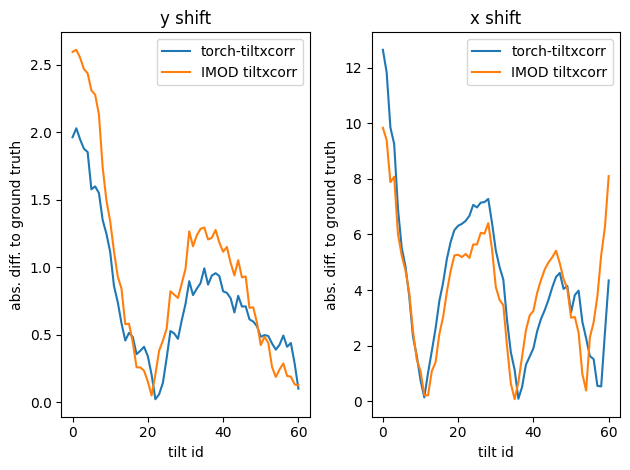

In [4]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(torch_xcorr_abs_diff[:, 0], label='torch-tiltxcorr')
ax[0].plot(imod_xcorr_abs_diff[:, 0], label='IMOD tiltxcorr')
ax[0].set_xlabel('tilt id')
ax[0].set_ylabel('abs. diff. to ground truth')
ax[0].legend()
ax[0].set_title('y shift')
ax[1].plot(torch_xcorr_abs_diff[:, 1], label='torch-tiltxcorr')
ax[1].plot(imod_xcorr_abs_diff[:, 1], label='IMOD tiltxcorr')
ax[1].set_xlabel('tilt id')
ax[1].set_ylabel('abs. diff. to ground truth')
ax[1].legend()
ax[1].set_title('x shift')
plt.tight_layout()
plt.show()